In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [51]:
#LSTM without TenYear
df = pd.read_excel('InlandEmpirePredict1.xlsx')

In [52]:
df['Period'] = pd.to_datetime(df['Period'], format='%b %Y')
df = df.sort_values('Period')

In [53]:
df['RevPAR'] = df['RevPAR'].astype(str).str.replace('$', '').astype(float)

In [54]:
df.set_index('Period', inplace=True)

In [55]:
scaler = MinMaxScaler(feature_range=(0, 1))
df['RevPAR'] = scaler.fit_transform(df[['RevPAR']])

In [56]:
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

In [57]:
time_step = 10
X, Y = create_dataset(df[['RevPAR']].values, time_step)

In [58]:
X = X.reshape(X.shape[0], X.shape[1], 1)

In [59]:
train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

In [60]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))

In [61]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [62]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 10, 50)            10400     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [63]:
model.fit(X_train, Y_train, epochs=2, batch_size=64, validation_data=(X_test, Y_test), verbose=1)

Epoch 1/2
5/5 [==============================] - 6s 266ms/step - loss: 0.0390 - val_loss: 0.0983
Epoch 2/2
5/5 [==============================] - 0s 24ms/step - loss: 0.0141 - val_loss: 0.0303


In [64]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

5/5 [==============================] - 0s 8ms/step


In [65]:
train_predict_full = np.zeros((train_predict.shape[0], 1))
train_predict_full[:, 0] = train_predict[:, 0]
test_predict_full = np.zeros((test_predict.shape[0], 1))
test_predict_full[:, 0] = test_predict[:, 0]

In [66]:
train_predict = scaler.inverse_transform(train_predict_full)[:, 0]
test_predict = scaler.inverse_transform(test_predict_full)[:, 0]

In [67]:
Y_train_actual = scaler.inverse_transform(Y_train.reshape(-1, 1))[:, 0]
Y_test_actual = scaler.inverse_transform(Y_test.reshape(-1, 1))[:, 0]

In [68]:
train_mse = mean_squared_error(Y_train_actual, train_predict)
test_mse = mean_squared_error(Y_test_actual, test_predict)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
train_mae = mean_absolute_error(Y_train_actual, train_predict)
test_mae = mean_absolute_error(Y_test_actual, test_predict)

In [69]:
print("Train MSE: ", train_mse)
print("Test MSE: ", test_mse)
print("Train RMSE: ", train_rmse)
print("Test RMSE: ", test_rmse)
print("Train MAE: ", train_mae)
print("Test MAE: ", test_mae)


Train MSE:  202.12069534419427
Test MSE:  457.24607681584195
Train RMSE:  14.216915816877945
Test RMSE:  21.38331304582716
Train MAE:  12.391586652835427
Test MAE:  14.547200710714735


1/1 [==============================] - 0s 31ms/step


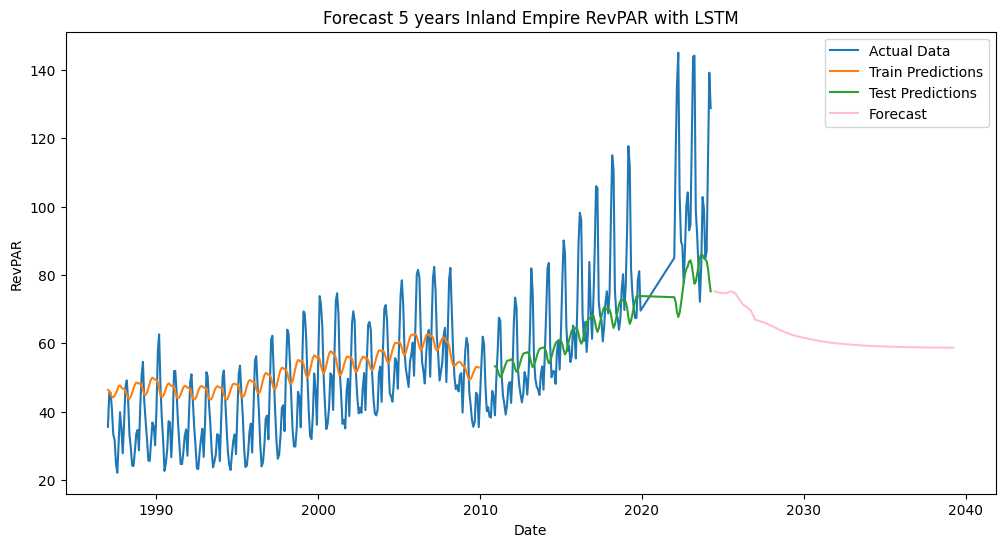

In [70]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, scaler.inverse_transform(df[['RevPAR']])[:, 0], label='Actual Data')
plt.plot(df.index[:len(train_predict)], train_predict, label='Train Predictions')
plt.plot(df.index[len(train_predict) + time_step + 1:], test_predict, label='Test Predictions')

X_input = X[-1].reshape((1, time_step, 1))
forecast = []
for i in range(60):
    next_pred = model.predict(X_input)
    forecast.append(next_pred[0, 0])
    X_input = np.append(X_input[:, 1:, :], next_pred.reshape(1, 1, 1), axis=1)

forecast_full = np.zeros((len(forecast), 1))
forecast_full[:, 0] = forecast
forecast = scaler.inverse_transform(forecast_full)[:, 0]

last_date = df.index[-1]
future_dates = [last_date + pd.DateOffset(months=3 * i) for i in range(1, 61)]

# Plot forecasted values
plt.plot(future_dates, forecast, label='Forecast', color='pink')

plt.xlabel('Date')
plt.ylabel('RevPAR')
plt.title('Forecast 5 years Inland Empire RevPAR with LSTM')
plt.legend()
plt.show()

In [71]:
print("Forecast for the next 3 months:")
for i, val in enumerate(forecast, 1):
    print(f"Month {i}: ${val:.2f}")

Forecast for the next 3 months:
Month 1: $75.21
Month 2: $74.82
Month 3: $74.63
Month 4: $74.76
Month 5: $75.19
Month 6: $74.74
Month 7: $72.96
Month 8: $71.34
Month 9: $70.51
Month 10: $69.48
Month 11: $66.88
Month 12: $66.55
Month 13: $66.15
Month 14: $65.68
Month 15: $65.15
Month 16: $64.55
Month 17: $63.95
Month 18: $63.42
Month 19: $62.97
Month 20: $62.53
Month 21: $62.14
Month 22: $61.88
Month 23: $61.61
Month 24: $61.35
Month 25: $61.10
Month 26: $60.87
Month 27: $60.65
Month 28: $60.46
Month 29: $60.30
Month 30: $60.14
Month 31: $60.01
Month 32: $59.89
Month 33: $59.77
Month 34: $59.67
Month 35: $59.57
Month 36: $59.48
Month 37: $59.40
Month 38: $59.33
Month 39: $59.26
Month 40: $59.21
Month 41: $59.15
Month 42: $59.10
Month 43: $59.06
Month 44: $59.02
Month 45: $58.98
Month 46: $58.95
Month 47: $58.92
Month 48: $58.89
Month 49: $58.86
Month 50: $58.84
Month 51: $58.82
Month 52: $58.80
Month 53: $58.78
Month 54: $58.77
Month 55: $58.75
Month 56: $58.74
Month 57: $58.73
Month 58